In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from fact.io import read_h5py
exec(open('/home/msackel/Desktop/gammaClassification/programm/theta_cut/theta_cut.py').read())
exec(open('/home/msackel/Desktop/gammaClassification/programm/model_significance/model_significance.py').read())
plt.style.use('msackel')


with open('/home/msackel/Desktop/gammaClassification/config/feature.yaml') as f:
    feature = yaml.load(f)

mess_hadron= read_h5py(
    '/home/msackel/Desktop/gammaClassification/data/raw_data/crab_precuts.hdf5',
    key='events',
    columns=list(feature)+['theta_deg']
    )

mc_hadron= pd.read_hdf('/home/msackel/Desktop/gammaClassification/data/raw_data/proton_precuts.hdf5')[feature+['theta_deg']]

In [10]:
mess_hadron= mess_hadron.query('theta_deg>='+str(np.sqrt(0.5)))[:100000]
mc_hadron= mc_hadron[:100000]
mess_hadron['label']=1
mc_hadron['label']=0
data = pd.concat([mess_hadron.drop('theta_deg', axis=1), mc_hadron.drop('theta_deg', axis=1)])
X_train, X_test, y_train, y_test = train_test_split(data.drop(['label'], axis=1), data.label, random_state=42)

In [14]:
Forest = RandomForestClassifier(
    max_depth=15,
    n_jobs=15,
    n_estimators=100, 
    criterion='entropy'
)
Forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=15, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [26]:
pre = Forest.predict_proba(X_test)[:,1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test.values,pre)

0.63623959806099817

In [5]:
Tree = RandomForestClassifier(max_depth=15, criterion='entropy', n_estimators=100, n_jobs=25)

eval_data = read_h5py(
				'/home/msackel/Desktop/gammaClassification/data/raw_data/crab_precuts.hdf5',
				key='events',
				columns=list(feature) + [
						'theta_deg',
						'theta_deg_off_1',
						'theta_deg_off_2',
						'theta_deg_off_3',
						'theta_deg_off_4',
						'theta_deg_off_5',
						]
				)

print('---Theta**2 = 0.5')
train_data = theta_cut('/home/msackel/Desktop/gammaClassification/data/raw_data/gamma_precuts.hdf5', 
					'/home/msackel/Desktop/gammaClassification/data/raw_data/crab_precuts.hdf5', 0.5) 

Tree.fit(train_data.drop('label', axis=1), train_data.label)

plot_significance(Tree, eval_data, path='plots/significance_crab.pdf')

---Theta**2 = 0.5


In [6]:
new_feature = ['conc_core',
 'concentration_one_pixel',
 #'concentration_two_pixel',
 'leakage',
 #'leakage2',
 'size',
 #'width',
 'num_islands',
 'num_pixel_in_shower',
 #'ph_charge_shower_max',
 'ph_charge_shower_mean',
 'ph_charge_shower_variance']

In [7]:
new_Tree = RandomForestClassifier(max_depth=15, criterion='entropy', n_estimators=100, n_jobs=28)
new_Tree.fit(train_data[new_feature], train_data.label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=28, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [8]:
eval_data['pred_tree'] = new_Tree.predict_proba(eval_data[new_feature])[:,1]

In [9]:
pred_Tree = np.array([])
for x in np.linspace(0.5,1,50):
    on_data, off_data = split_on_off_source_independent(eval_data.query('pred_tree>= '+str(x)), theta2_cut=0.03) 
    pred_Tree = np.append(pred_Tree, li_ma_significance(len(on_data), len(off_data), 0.2))

/home/msackel/.conda/envs/msackel/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


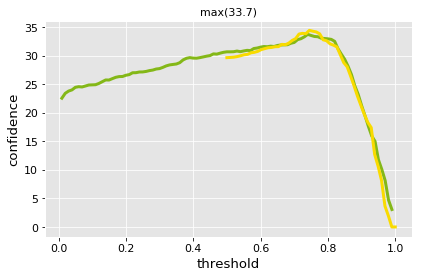

34.397024526151881

In [10]:
plt.plot(np.linspace(0.5,1,50),pred_Tree)
plt.show()
max(pred_Tree)

In [23]:
plt.figure()
plt.barh(np.linspace(0,3,len(Tree.feature_importances_))-0.09,
        Tree.feature_importances_, 
        height=1/len(Tree.feature_importances_), label='Gamma/Hadron Sep.')
plt.barh(np.linspace(0,3,len(Forest.feature_importances_)),
        Forest.feature_importances_, 
        height=1/len(Tree.feature_importances_),
        tick_label=mc_hadron.drop(['theta_deg','label'], axis=1).keys(),
        label='Mess/MC Sep.')
plt.xlabel('Gewichte')
#plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=2)
plt.savefig('feature_elemination.pdf')

In [12]:
from xgboost.sklearn import XGBClassifier

In [13]:
xgbc = XGBClassifier(
                max_depth= 3,
                learning_rate= 0.28,
                booster= 'gbtree',
                gamma=1,
                n_jobs= 15,
                min_child_weight=0.6,
                #reg_lambda= 0.5,
                subsample= 0.25,
                eval_metric= 'auc'
                )

In [14]:
xgbc.fit(train_data[new_feature], train_data.label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=1, learning_rate=0.28,
       max_delta_step=0, max_depth=3, min_child_weight=0.6, missing=None,
       n_estimators=100, n_jobs=15, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.25)

In [15]:
eval_data['pred_xgbc'] = xgbc.predict_proba(eval_data[new_feature])[:,1]

In [16]:
pred_Tree = np.array([])
for x in np.linspace(0.5,1,50):
    on_data, off_data = split_on_off_source_independent(eval_data.query('pred_xgbc>= '+str(x)), theta2_cut=0.03) 
    pred_Tree = np.append(pred_Tree, li_ma_significance(len(on_data), len(off_data), 0.2))

/home/msackel/.conda/envs/msackel/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


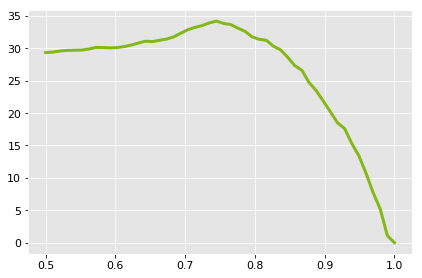

34.148647280789028

In [17]:
plt.plot(np.linspace(0.5,1,50),pred_Tree)
plt.show()
max(pred_Tree)